           time  bpm
0    1699948256  109
1    1699948258  108
2    1699948258  107
3    1699948259  103
4    1699948260   98
..          ...  ...
374  1699948635   80
375  1699948636   80
376  1699948637   80
377  1699948638   80
378  1699948639   80

[379 rows x 2 columns]
           time  bpm  cluster
0    1699948256  109        1
1    1699948258  108        1
2    1699948258  107        1
3    1699948259  103        1
4    1699948260   98        1
..          ...  ...      ...
374  1699948635   80        0
375  1699948636   80        0
376  1699948637   80        0
377  1699948638   80        0
378  1699948639   80        0

[379 rows x 3 columns]


/Users/k22120kk/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/17/hr77rhls56s9jxwlkbvyzmz80000gn/T/ipykernel_77027/1265050357.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nervous' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data['cluster'] == high_cluster, 'state'] = 'nervous'


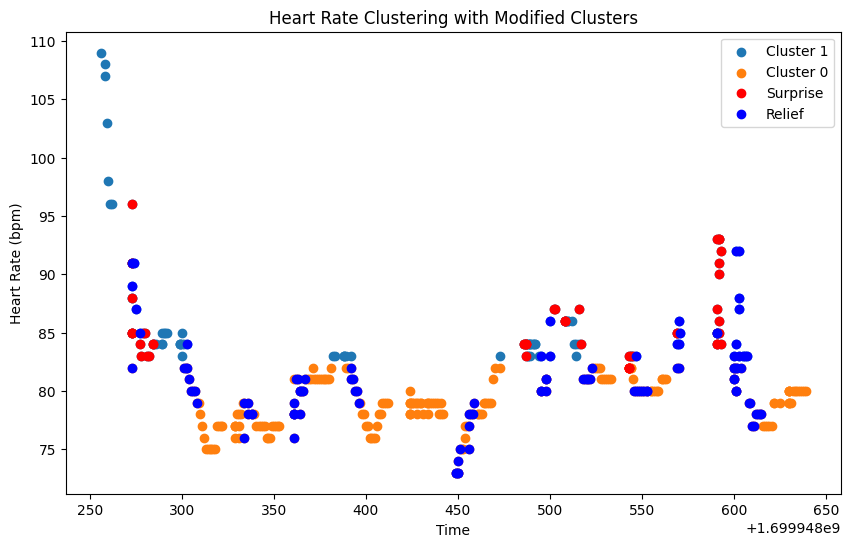

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

def read_csv_data(file_path):
    """CSVデータを読み込みDataFrameに変換する"""
    return pd.read_csv(file_path)

def preprocess_data(data):
    """心拍数データを抽出し、標準化する"""
    heart_rate = data['bpm'].values.reshape(-1, 1)
    scaler = StandardScaler()
    return scaler.fit_transform(heart_rate)

def perform_clustering(data, num_clusters=2):

    heart_rate_scaled = preprocess_data(data)

    """KMeansを用いてクラスタリングを行う"""
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(heart_rate_scaled)
    data['cluster'] = kmeans.labels_
    return data

def identify_extreme_clusters(data):
    """最高値と最低値のクラスタを特定する"""
    high_bpm_cluster = data[data['bpm'] == data['bpm'].max()]['cluster'].values[0]
    low_bpm_cluster = data[data['bpm'] == data['bpm'].min()]['cluster'].values[0]
    return high_bpm_cluster, low_bpm_cluster

def filter_states(data, high_cluster, low_cluster):
    """驚愕と安堵のデータを抽出する"""
    df_surprise = data[(data['diff'] > 1) & (data['cluster'] == high_cluster)]
    df_relief = data[(data['diff'] < -1) & (data['cluster'] == low_cluster)]
    return df_surprise, df_relief

def update_states(data, surprise_data, relief_data):
    """条件に合致したデータの状態を変更する"""

    # clasterがhigh_bpm_clusterの時はnervous、low_bpm_clusterの時はnormalにする
    data.loc[data['cluster'] == high_cluster, 'state'] = 'nervous'
    data.loc[data['cluster'] == low_cluster, 'state'] = 'normal'

    for index in surprise_data.index:
        data.loc[index:index+5, 'state'] = 'surprise'
    for index in relief_data.index:
        data.loc[index:index+5, 'state'] = 'relief'

    return data

def plot_clusters(data):
    """クラスタリング結果をグラフで表示する"""
    plt.figure(figsize=(10, 6))
    for cluster in data['cluster'].unique():
        plt.scatter(data[data['cluster'] == cluster]['time'], data[data['cluster'] == cluster]['bpm'], label=f'Cluster {cluster}')

    plt.scatter(data[data['state'] == 'surprise']['time'], data[data['state'] == 'surprise']['bpm'], label='Surprise', color='red')
    plt.scatter(data[data['state'] == 'relief']['time'], data[data['state'] == 'relief']['bpm'], label='Relief', color='blue')

    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Clustering with Modified Clusters')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    data_paths = ["./data/21/east_bpm.csv", "./data/21/west_bpm.csv", "./data/21/south_bpm.csv", "./data/21/north_bpm.csv"]

    # データをマージして読み込む
    data_frames = []
    for file_path in data_paths:
        data = read_csv_data(os.path.join(file_path))
        data_frames.append(data)
        data = None


    data = pd.DataFrame()
    select_file = 2
    # data_frames[3]を10データずつ増やしてデータを作成
    # for i in range(0,len(data_frames[3])-10,10):
    print(data_frames[3])
    # dfの結合
    data = pd.concat([data,data_frames[3]])
    # KMeansでクラスタリングを行う
    clustered_data = perform_clustering(data)
    print(clustered_data)

    clustered_data['diff'] = clustered_data['bpm'].diff()

    # クラスタの特定と状態の更新
    high_cluster, low_cluster = identify_extreme_clusters(clustered_data)

    surprise_states, relief_states = filter_states(clustered_data, high_cluster, low_cluster)

    updated_data = update_states(clustered_data, surprise_states, relief_states)
    

    # グラフの描画
    plot_clusters(updated_data)


In [6]:
updated_data

,time,bpm,cluster,diff,state
0,1699948256,109,1,NaN,nervous
1,1699948258,108,1,-1.0,nervous
2,1699948258,107,1,-1.0,nervous
3,1699948259,103,1,-4.0,nervous
4,1699948260,98,1,-5.0,nervous
...,...,...,...,...,...
374,1699948635,80,0,0.0,normal
375,1699948636,80,0,0.0,normal
376,1699948637,80,0,0.0,normal
377,1699948638,80,0,0.0,normal
